<a href="https://colab.research.google.com/github/nicole-whitlock/games/blob/main/Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
from langdetect import detect, DetectorFactory
import kagglehub
import os
from google.colab import drive
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from time import time
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

DetectorFactory.seed = 0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('/content/metacritic_english_reviews.csv')

In [3]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

print("\nPreprocessing text...")
df['processed_text'] = df['quote'].apply(preprocess_text)


Preprocessing text...


In [5]:
df.to_csv('/content/processed_english_reviews.csv', index=False)

Turning the score column (0-100) into sentiment categories

In [6]:
# Create 3 sentiment categories
df['sentiment'] = np.where(
    df['score'] >= 70, 'positive',
    np.where(df['score'] <= 40, 'negative', 'neutral')
)

In [11]:
df = df.dropna(subset=['score'])

In [12]:
subset_df, _ = train_test_split(df,
                                train_size=0.1,
                                stratify=df['score'],
                                random_state=42)


In [13]:
# Train-Test Split
X = subset_df['processed_text']
y = subset_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Preserve class distribution
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("\nVectorizing text data...")
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=5,            # Ignore rare terms
    max_df=0.7           # Ignore overly common terms
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


Training samples: 118417
Test samples: 29605

Vectorizing text data...


In [14]:
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    # Time training
    start_time = time()
    model.fit(X_train, y_train)
    train_time = time() - start_time

    # Predict and evaluate
    start_time = time()
    y_pred = model.predict(X_test)
    inference_time = time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Inference time: {inference_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'model': model_name,
        'accuracy': accuracy,
        'train_time': train_time,
        'inference_time': inference_time
    }

In [15]:
# Dictionary to store results
results = []

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=1.0)
lr_results = evaluate_model("Logistic Regression", lr_model,
                           X_train_vec, X_test_vec,
                           y_train, y_test)
results.append(lr_results)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model("Random Forest", rf_model,
                           X_train_vec, X_test_vec,
                           y_train, y_test)
results.append(rf_results)

# Support Vector Machine
svm_model = LinearSVC(C=1.0)
svm_results = evaluate_model("Linear SVM", svm_model,

                             X_train_vec, X_test_vec,
                           y_train, y_test)
results.append(svm_results)

# Naive Bayes
nb_model = MultinomialNB()
nb_results = evaluate_model("Naive Bayes", nb_model,
                           X_train_vec, X_test_vec,
                           y_train, y_test)
results.append(nb_results)



Logistic Regression Results:
Accuracy: 0.8165
Training time: 21.61 seconds
Inference time: 0.02 seconds

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.72      0.75      5628
     neutral       0.52      0.26      0.35      3938
    positive       0.85      0.95      0.90     20039

    accuracy                           0.82     29605
   macro avg       0.72      0.64      0.67     29605
weighted avg       0.79      0.82      0.80     29605


Random Forest Results:
Accuracy: 0.7822
Training time: 621.23 seconds
Inference time: 3.21 seconds

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.61      0.69      5628
     neutral       0.55      0.05      0.09      3938
    positive       0.78      0.98      0.87     20039

    accuracy                           0.78     29605
   macro avg       0.71      0.54      0.55     29605
weighted avg       0.75      0.78      0

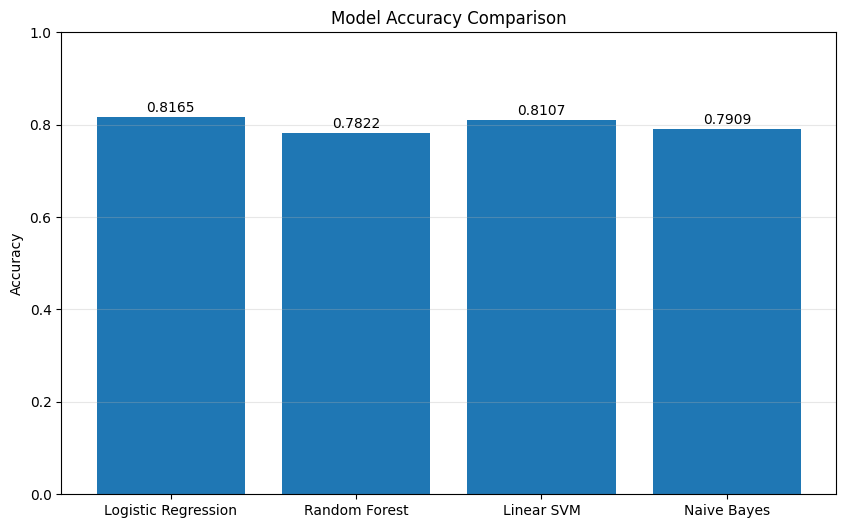

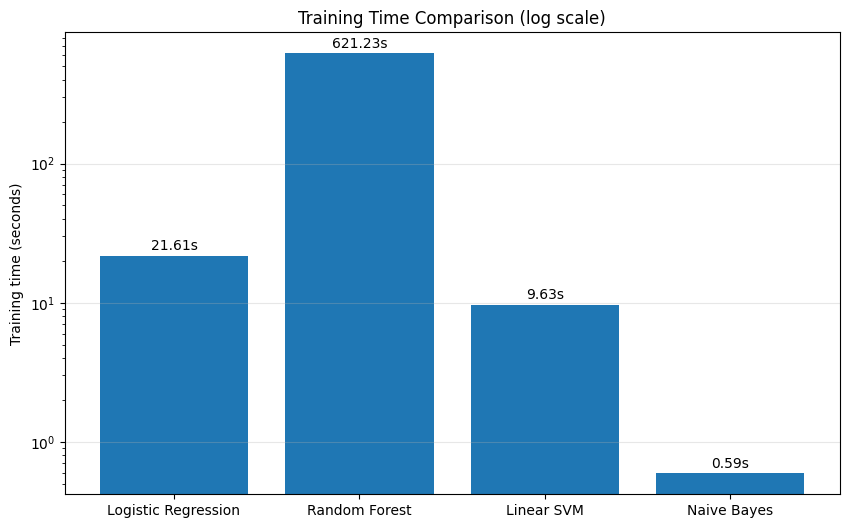

In [16]:
import matplotlib.pyplot as plt

# Accuracy comparison
plt.figure(figsize=(10, 6))
model_names = [result['model'] for result in results]
accuracies = [result['accuracy'] for result in results]

plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v+0.01, f"{v:.4f}", ha='center')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Training time comparison (log scale for better visualization)
plt.figure(figsize=(10, 6))
train_times = [result['train_time'] for result in results]
plt.bar(model_names, train_times)
plt.title('Training Time Comparison (log scale)')
plt.yscale('log')
plt.ylabel('Training time (seconds)')
for i, v in enumerate(train_times):
    plt.text(i, v*1.1, f"{v:.2f}s", ha='center')
plt.grid(axis='y', alpha=0.3)
plt.show()